We now have our generated dataset a segmentation function which returns our grain map. The final step, then, is to analyse the statistics of grain distribution.
We are interested in the distribution of:
- grain size
- no. grains
- grain ellipse-of-best-fit aspect ratio
- closeness to best ellipse

In [2]:
import torch
import numpy as np
from image_processing import segment
from apd_dataset_constructor import APDDataset
import matplotlib.pyplot as plt

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
training_data = APDDataset('test_dataset',size=(64,64))
gen_data = APDDataset('gen_data', size=(1,64,64))

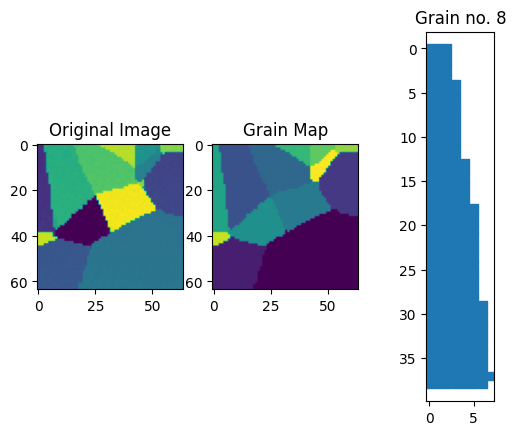

In [4]:
# We can extract the coordinates of each grain using our segmentation function and np.argwhere:

img = gen_data.__getitem__(4562).transpose(0,-1).numpy()
grain_map = segment(img)
grain_id = 8
grain_coords = np.argwhere(grain_map == grain_id)

# Plot results:
fig, ax = plt.subplots(1,3)
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(grain_map)
ax[1].set_title("Grain Map")
ax[2].scatter(grain_coords[:,1], grain_coords[:,0], marker='s')
ax[2].yaxis.set_inverted(True)
ax[2].set_aspect(1)
ax[2].set_title(f"Grain no. {grain_id}")

plt.show()

Now that we have our grain coordinates, we could find the ellipse that best explains the shape of the data in the sense of principal component analysis. That is, we find the direction who's projection has the greatest variance, and call this our principal axis. Diagonalising the sample variance matrix therefore gives us the variances along each principal component, and consequently the square roots of the eigenvalues give us standard deviations in each direction, and so their ratio makes sense as an aspect ratio.

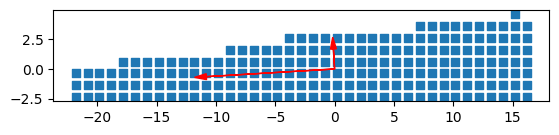

In [27]:
# First centre the data:
X = grain_coords - grain_coords.mean(axis=0)
n = len(X)
assert n > 1
S = 1/(n-1) * X.transpose() @ X

U, D, _ = np.linalg.svd(S)
#print(U[:,0])

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.scatter(X[:,0], X[:,1], marker='s')
ax.arrow(0,0, U[0][0]*np.sqrt(D[0]), U[1][0]*np.sqrt(D[0]),head_width=0.5, head_length=1, color='red')
ax.arrow(0,0, U[0][1]*np.sqrt(D[1]), U[1][1]*np.sqrt(D[1]),head_width=0.5, head_length=1, color='red')


In [6]:
# Thus we are able to get the size, aspect ratio and orientation of our grains!
def get_grain_stats(grain_coords: np.array):
    size = len(grain_coords)
    assert size > 0
    X = grain_coords - grain_coords.mean(axis=0)

    S = X.transpose() @ X

    U, D, _ = np.linalg.svd(S)

    aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])

    angle = np.arctan2(U[0,0], U[1,0]) % np.pi

    return size, aspect_ratio, angle

import pandas as pd
print()


Ignore the following once we have the grain statistics, instead load the csvs below

In [7]:
gen_grain_data = pd.DataFrame(columns=['img_id', 'grain_id','size','aspect ratio', 'angle'])
i = 0
for img_id in range(len(gen_data)):
    img = gen_data.__getitem__(img_id).transpose(0,-1).numpy()
    grain_map = segment(img)
    for grain_id in np.unique(grain_map):
        coords = np.argwhere(grain_map == grain_id)
        size, aspect, angle = get_grain_stats(coords)
        gen_grain_data.loc[i] = [img_id, grain_id, size, aspect, angle]
        i += 1
        if img_id % 500 == 0 and grain_id == 0:
            print(f"Dataset 1, {img_id}/{len(gen_data)}")

/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1195/416369

KeyboardInterrupt: 

In [161]:
gen_grain_data.to_csv("gen_grain_data.csv")

In [153]:
training_grain_data = pd.DataFrame(columns=['img_id', 'grain_id','size','aspect ratio', 'angle'])
i = 0
for img_id in range(len(training_data)):
    img = training_data.__getitem__(img_id).transpose(0,-1).numpy()
    grain_map = (255 * (img + 1)/2).astype(np.uint8)
    for grain_id, intensity in enumerate(np.unique(grain_map)):
        coords = np.argwhere(grain_map == intensity)
        size, aspect, angle = get_grain_stats(coords)
        training_grain_data.loc[i] = [img_id, grain_id, size, aspect, angle]
        i += 1
        if img_id % 500 == 0 and grain_id == 0:
            print(f"Dataset 2, {img_id}/{len(training_data)}")

Dataset 2, 0/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 1000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 1500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 2000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 2500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 3000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 3500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 4000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 4500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 5000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 5500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 6000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 6500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 7000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 7500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 8000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 8500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 9000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 9500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 10000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 10500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 11000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 11500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 12000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 12500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 13000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 13500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 14000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 14500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 15000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 15500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 16000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 16500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 17000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 17500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 18000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 18500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 19000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_100

Dataset 2, 19500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 20000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 20500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 21000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 21500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 22000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 22500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 23000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 23500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 24000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 24500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 25000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: invalid value encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10

Dataset 2, 25500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 26000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 26500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 27000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 27500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 28000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 28500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 29000/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

Dataset 2, 29500/30000


/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_10054/4163690522.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  aspect_ratio = np.sqrt(D[0])/np.sqrt(D[1])
/var/folders/2f/tq8kfzld4zgc6kdw50dr8mmh0000gn/T/ipykernel_1

In [158]:
training_grain_data.to_csv('training_grain_data.csv')

In [8]:
gen_grain_data = pd.read_csv("gen_grain_data.csv")
training_grain_data = pd.read_csv("training_grain_data.csv")


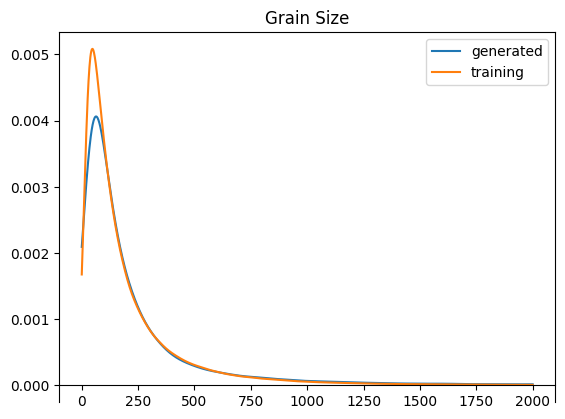

In [17]:
from scipy.stats import gaussian_kde
gen_sizes_kde = gaussian_kde(gen_grain_data['size'])
target_sizes_kde = gaussian_kde(training_grain_data['size'])

fig, ax = plt.subplots()
xs = np.linspace(0, 2000, 1000)
y1s = gen_sizes_kde(xs)
y2s = target_sizes_kde(xs)

ax.plot(xs, y1s, label="generated")
ax.plot(xs, y2s, label="training")
ax.legend()
ax.spines['bottom'].set_position(('data', 0))
ax.set_title("Grain Size")
plt.show()

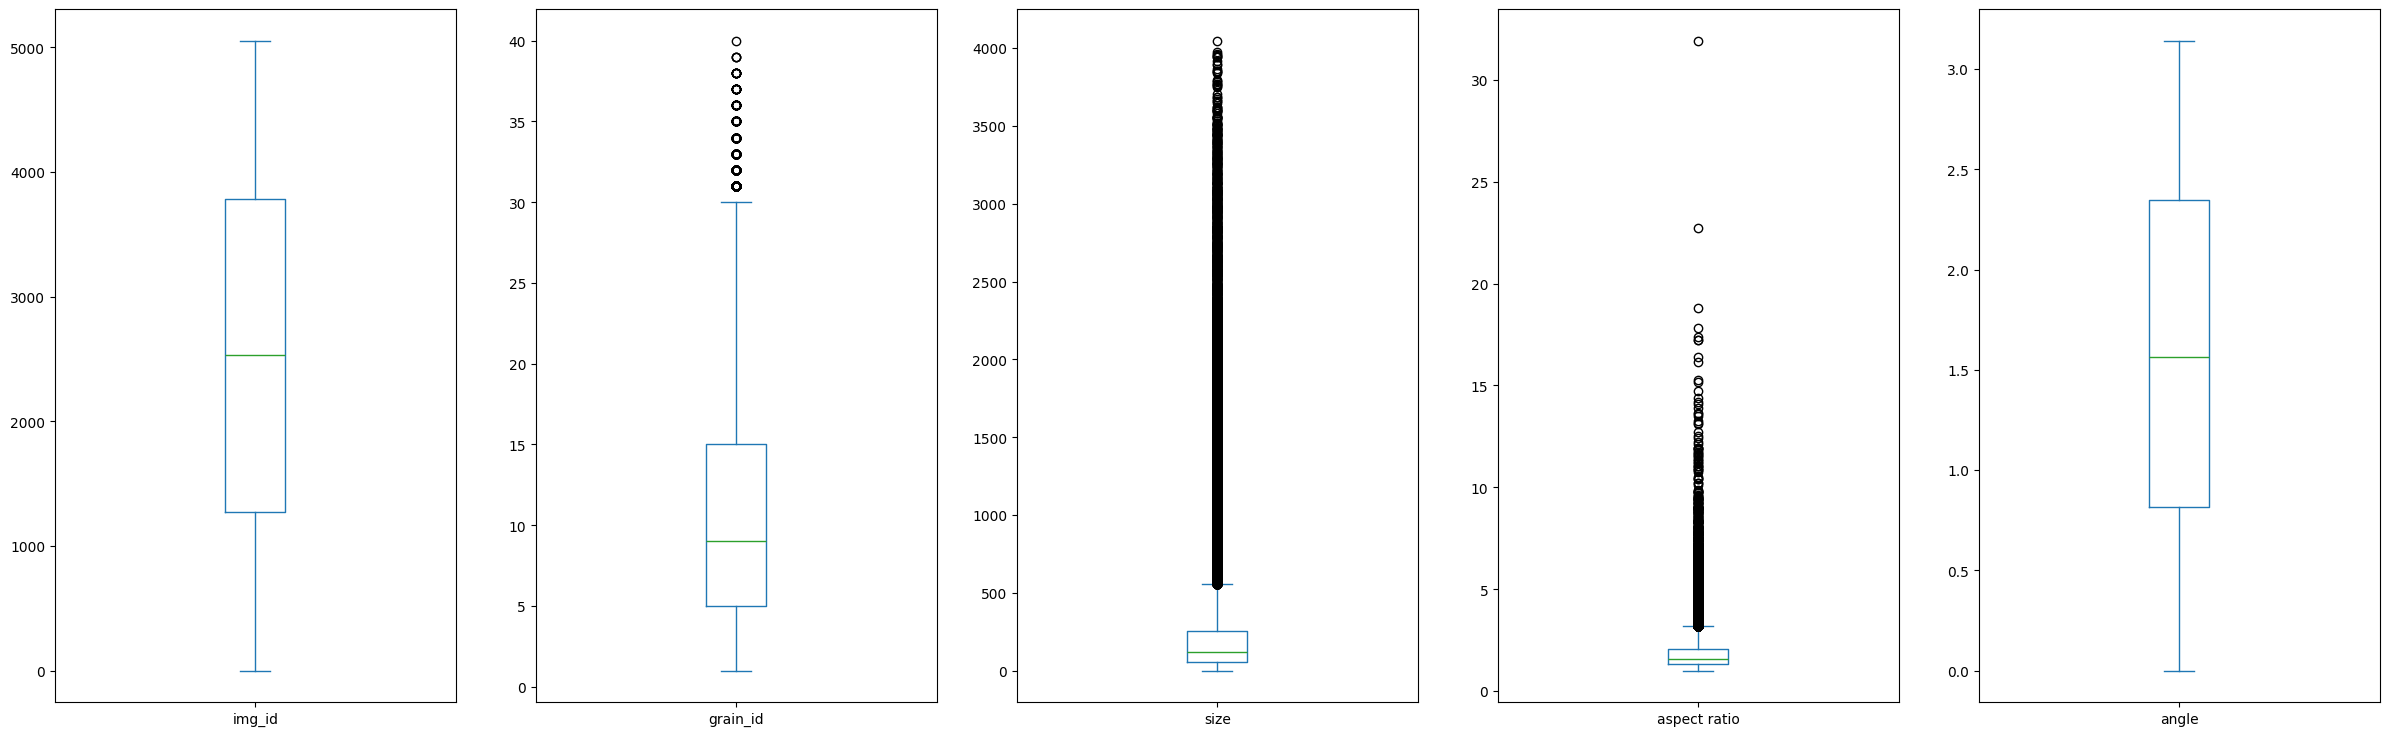

In [229]:
fig, axes = plt.subplots(1,5, figsize=(30, 9))
for i, col in enumerate(gen_grain_data):
    if i == 0: # Not interested in index col
        continue
    gen_grain_data[col].plot.box(ax=axes[i-1])
#training_grain_data[training_grain_data['aspect ratio'] < 100].boxplot()
plt.show()

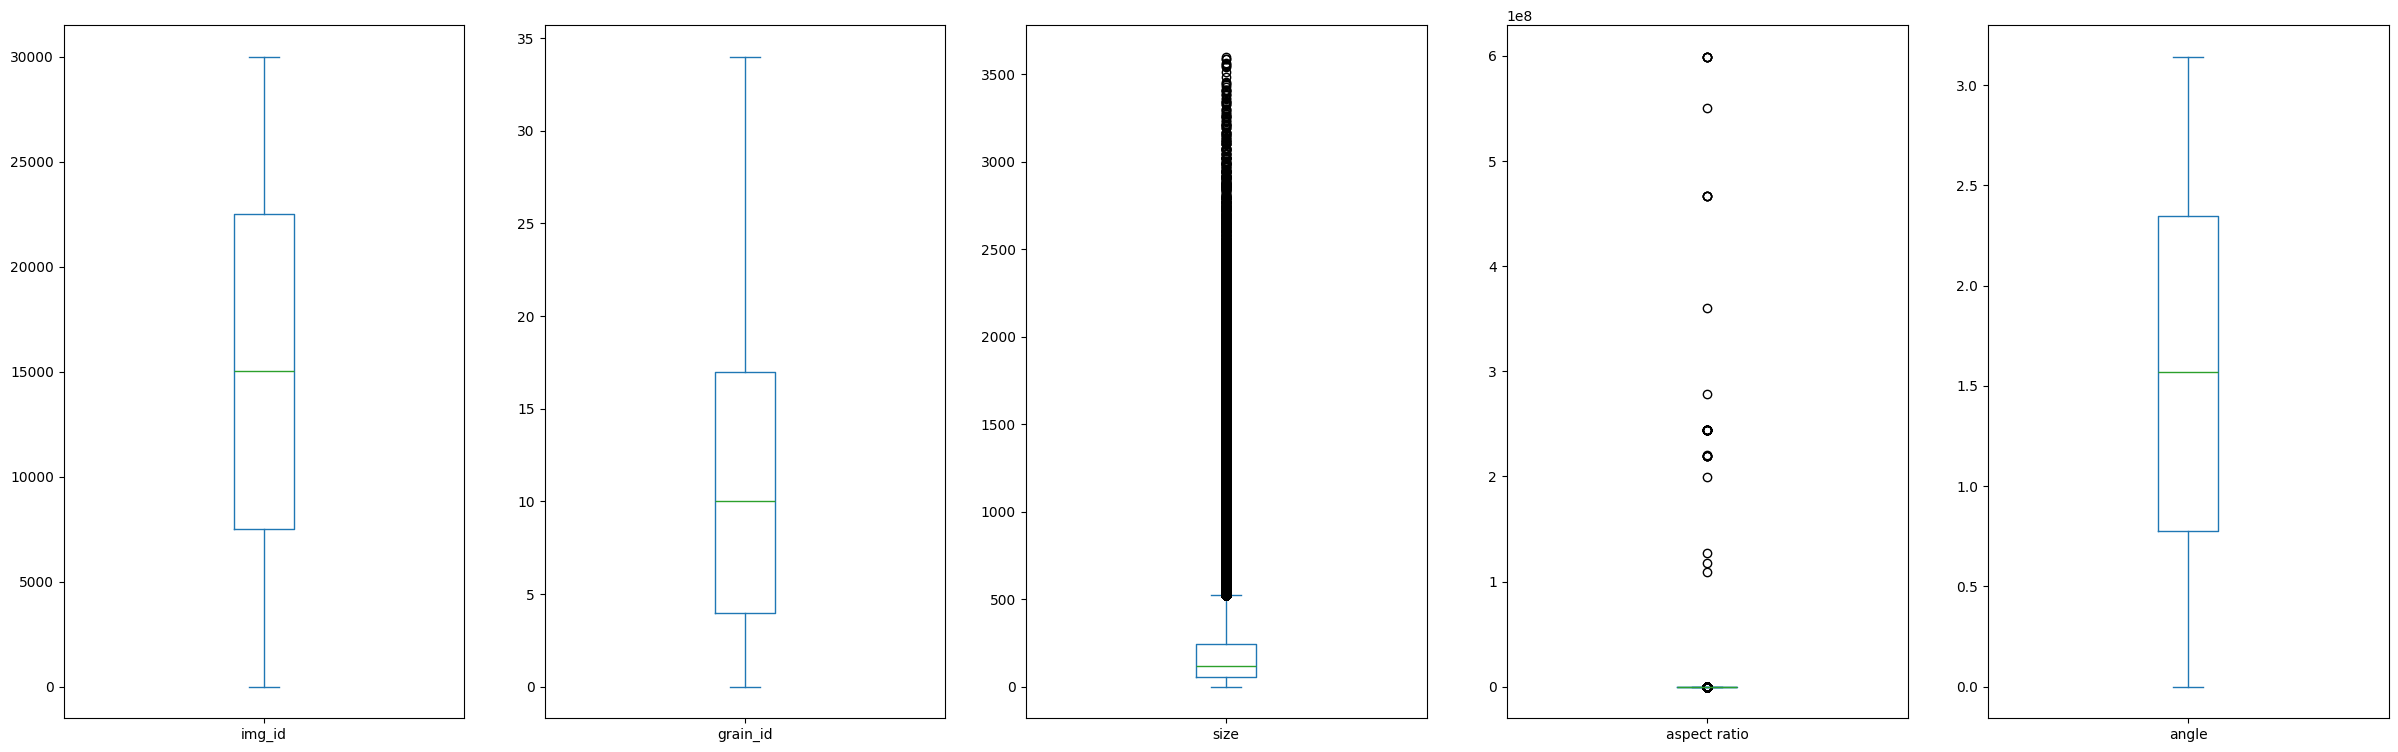

In [14]:
fig, axes = plt.subplots(1,5, figsize=(30, 9))
for i, col in enumerate(training_grain_data):
    if i == 0: # Not interested in index col
        continue
    training_grain_data[col].plot.box(ax=axes[i-1])
#training_grain_data[training_grain_data['aspect ratio'] < 100].boxplot()
plt.show()

<Axes: >

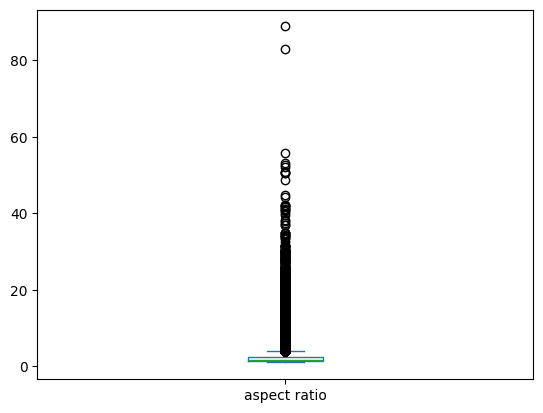

In [232]:
# We see the aspect ratio distribution is obscured by a small number of outliers:
training_grain_data['aspect ratio'][training_grain_data['aspect ratio'] < 90.5].plot.box()

7.718587028746702e-05


<Axes: >

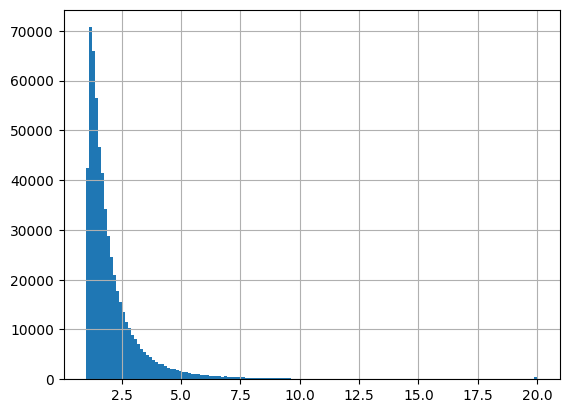

In [219]:
len(training_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna())

training_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna()[550000:551000]
training_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna().describe()

print((training_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna() > 100).mean())
training_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna().clip(upper=20).hist(bins=150)

Text(0.5, 1.0, 'Grain Aspect Ratio')

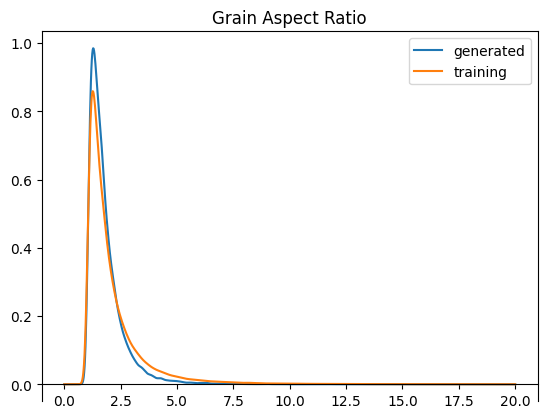

In [21]:
#gen_asp_kde = gaussian_kde(gen_grain_data['aspect ratio'].replace(np.inf, np.nan).dropna())
gen_asp_kde = gaussian_kde(gen_grain_data['aspect ratio'][gen_grain_data['aspect ratio'] < 90.5])
target_asp_kde = gaussian_kde(training_grain_data['aspect ratio'][training_grain_data['aspect ratio'] < 90.5])

xs = np.linspace(0,20, 1000)
y1s = gen_asp_kde(xs)
y2s = target_asp_kde(xs)

fig, ax = plt.subplots()
ax.plot(xs, y1s, label="generated")
ax.plot(xs, y2s, label="training")
ax.legend()
ax.spines['bottom'].set_position(('data', 0))
ax.set_title("Grain Aspect Ratio")

' ax.plot(xs, y1s)\nax.plot(xs, y2s)\nax.set_title("Angle") '

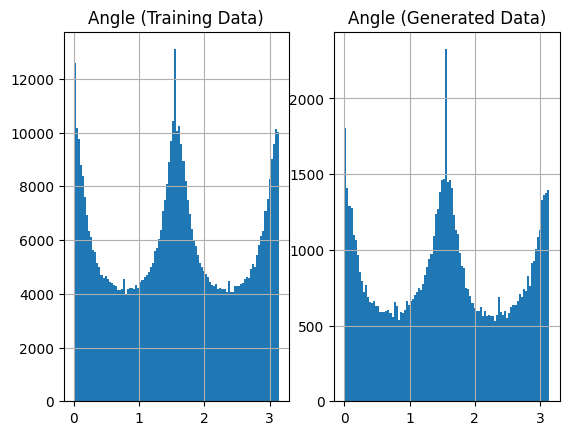

In [245]:
gen_angle_kde = gaussian_kde(gen_grain_data['angle'])
target_angle_kde = gaussian_kde(training_grain_data['angle'])
xs = np.linspace(0, np.pi, 1000)
y1s = gen_angle_kde(xs)
y2s = target_angle_kde(ys)

fig, ax = plt.subplots(1, 2)

training_grain_data['angle'].hist(ax=ax[0], bins=100)
gen_grain_data['angle'].hist(ax=ax[1], bins=100)
ax[0].set_title("Angle (Training Data)")
ax[1].set_title("Angle (Generated Data)")

On inspection, the model seems to have captured the distributions of features reasonably well, but has had problems capturing the high densities at the peaks for the size and aspect ratio variables. How can we quantify this? We can apply the Kolmogorov-Smirnov test to the marginal distributions of grain size, angle, and aspect ratio to see if we can reject the null hypothesis that both samples are drawn from the same distribution.

In [25]:
gen_grain_data.head()

,Unnamed: 0,img_id,grain_id,size,aspect ratio,angle
0,0,0.0,1.0,772.0,1.198438,0.350729
1,1,0.0,2.0,360.0,1.746412,1.604197
2,2,0.0,3.0,248.0,1.259631,1.377435
3,3,0.0,4.0,763.0,1.409006,0.102900
4,4,0.0,5.0,197.0,1.207007,1.590548


In [26]:
from scipy.stats import kstest

result1 = kstest(gen_grain_data['aspect ratio'][gen_grain_data['aspect ratio'] < 90.5], training_grain_data['aspect ratio'][training_grain_data['aspect ratio'] < 90.5])
result2 = kstest(gen_grain_data['angle'],training_grain_data['angle'])
result3 = kstest(gen_grain_data['size'], training_grain_data['size'])
print(result1)
print(result2)
print(result3)

KstestResult(statistic=0.09139008035264451, pvalue=0.0, statistic_location=2.316706133111529, statistic_sign=1)
KstestResult(statistic=0.010081994302014646, pvalue=5.083222165179136e-07, statistic_location=0.7848000775582991, statistic_sign=-1)
KstestResult(statistic=0.02236954189345064, pvalue=6.918911280809874e-33, statistic_location=604.0, statistic_sign=-1)


Thus we can conclude at the 1% (indeed more) significance level that the model has not succeeded in producing statistically equivalent microstructure samples. It is certainly possible that the model could benefit from further training, but as it stands this is clearly not an acceptable model to produce microstructures in the target distribution. However, it is interesting to note that in previous literature: in this 2025 paper https://arxiv.org/abs/2503.04776 achieved similar results which were improved by resampling the images 10 times.

In [29]:
mean1, std1 = gen_grain_data['size'].mean(), gen_grain_data['size'].std()
mean2, std2 = training_grain_data['size'].mean(), training_grain_data['size'].std()

print(f"Size, generated:   mean = {mean1}, std = {std1}")
print(f"Size, training:    mean = {mean2}, std = {std2}")

Size, generated:   mean = 242.75437815027547, std = 383.9321787322697
Size, training:    mean = 205.43238937195, std = 267.42525692648144
